# COMS 4771 Project
**Name: Ruizhe Li**  
**Uni: rl3070**  
Linear classifiers and other statistical classifiers usually does not work well and super hard to interprete on high dimensional inputs like an image. Thus, different CNNs are implemented in this project.   
This notebook contains 4 parts:  
1. Preparation: load packages and data
2. Vanila model: a simple CNN from scratch
3. Transfer learning and data augmentation: fine-tuned a pretrained base-model with augmented data
4. Interpretability: interpret the CNN model

### Preparation
In this section, we load packages and data.

In [1]:
from pathlib import Path
import os
import pandas as pd

import tensorflow as tf
import numpy as np
from google.colab import drive
drive.mount('/gdrive')

import matplotlib.pyplot as plt
from IPython.display import clear_output

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
ROOT = '/gdrive/My Drive/ML/Project/data'
TRAIN_ROOT = os.path.join(ROOT, 'train')
TEST_ROOT = os.path.join(ROOT, 'test')

train_csv_path = os.path.join(ROOT, 'train.csv')
test_csv_path = os.path.join(ROOT, 'test.csv')

### Vanila Model
First, build a CNN model from scratch without any other techniques.

In [0]:
train_csv = pd.read_csv(train_csv_path, index_col='id')
test_csv = pd.read_csv(test_csv_path, index_col='id')

In [0]:
# set constant parameters

IMAGE_CNT = train_csv.shape[0]

BATCH_SIZE = 32

VAL_SPLIT = 0.2
AUTOTUNE = tf.data.experimental.AUTOTUNE

BUFFER_SIZE = 512

int2label = list(train_csv['label'].unique())
label2int = {label: i for i, label in enumerate(int2label)}

CLASS_WEIGHT = {label2int[x]:1 for x in label2int}
CLASS_WEIGHT[label2int['covid']] = 5

IMG_HEIGHT = 256
IMG_WIDTH = 256

In [0]:
# transform file name to absolute file path

train_csv['filepath'] = train_csv['filename'].transform(lambda filename: os.path.join(TRAIN_ROOT, filename))
test_csv['filepath'] = test_csv['filename'].transform(lambda filename: os.path.join(TEST_ROOT, filename))

In [0]:
# load and preprocess images

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process(filepath, y=None):
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  if y is None:
    return img
  return img, y

In [0]:
# change categorical label to integers for one-hot encoding later.

train_csv['class'] = train_csv['label'].transform(lambda label: label2int[label])

In [0]:
# prepare training data and testing data

X, y = train_csv['filepath'], train_csv['class']
ds = tf.data.Dataset.from_tensor_slices((X,y)).map(process, num_parallel_calls=AUTOTUNE).cache() # preprocess and cache the result for efficiency

# split data to train-80%, val-20%

train_ds = ds.skip(np.ceil(IMAGE_CNT*VAL_SPLIT)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = ds.take(np.floor(IMAGE_CNT*VAL_SPLIT)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# load test data

test_ds = tf.data.Dataset.from_tensor_slices(test_csv['filename']).map(process, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [0]:
# implement the weighted accuracy
# the implementation might be different from the given function
# as I think the given function did not average properly

class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_sparse_categorical_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        # weight covid class by 5, other classes by 1
        weight = tf.cast(tf.where(y_true_int == label2int['covid'], 5, 1), tf.float32)
        return super().update_state(y_true, y_pred, sample_weight=weight)

In [0]:
# the function used to write output

def write_submission(y_pred, name=''):
  pd.Series(y_pred, name='label').transform(lambda x: int2label[x]).to_csv(name + 'submission.csv', index_label='id')

In [0]:
# evaluate and save the predictions

def eval_and_save(model, val_ds, test_ds, name=''):
  print('evaluating:')
  model.evaluate(val_ds, steps=val_ds.samples/BATCH_SIZE)

  print('predicting:')
  y_pred = model.predict(test_ds, workers=AUTOTUNE, use_multiprocessing=True, verbose=1, steps=test_ds.samples/BATCH_SIZE)
  y_pred = y_pred.argmax(axis=1)
  print(y_pred.shape)

  print('writing submission')
  write_submission(y_pred, name=name)

In [0]:
# plot the model's training history

def history_plot(history, name='vanila'):
  metrics = ['cat_acc', 'balanced_cat_acc', 'loss']
  names = ['Accuracy', 'Balanced Accuracy', 'Loss']
  
  plt.figure(figsize=(18, 5))
  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(history.history[metrics[i]])
    plt.plot(history.history['val_' + metrics[i]])
    plt.title('Model ' + names[i])
    plt.ylabel(names[i])
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
  plt.savefig(f'{name}.png')
  plt.show()

In [0]:
# build the vanila model from scratch

tf.keras.backend.clear_session()
vanila_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalMaxPooling2D(),
    # tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4, activation='softmax')
])

In [0]:
# compile and set callbacks

vanila_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='cat_acc'), BalancedSparseCategoricalAccuracy(name='balanced_cat_acc')])

mc = tf.keras.callbacks.ModelCheckpoint('vanila_model.h5', monitor='val_balanced_cat_acc', save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='val_balanced_cat_acc', patience=30, mode='max', baseline=None, restore_best_weights=True)

In [0]:
# train

vanila_history = vanila_model.fit(train_ds, class_weight=CLASS_WEIGHT, epochs=50, callbacks=[mc, es], validation_data=val_ds)

# output has been cleared
clear_output()

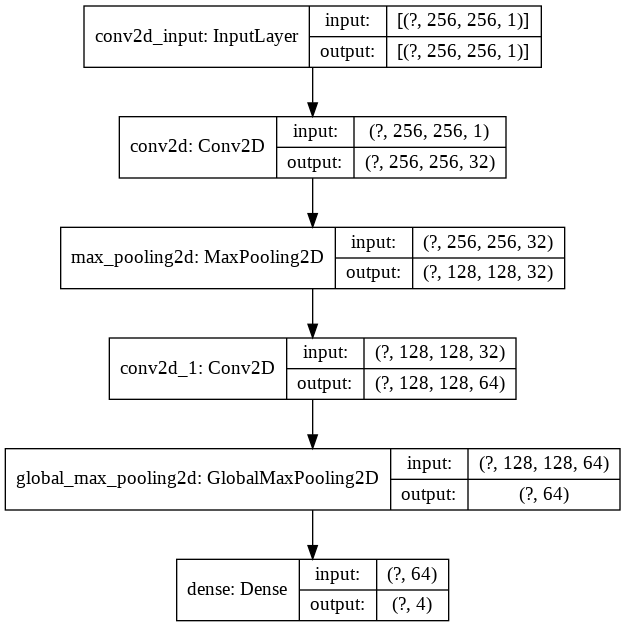

In [16]:
tf.keras.utils.plot_model(vanila_model, to_file='vanila_model.png', show_shapes=True, show_layer_names=True)

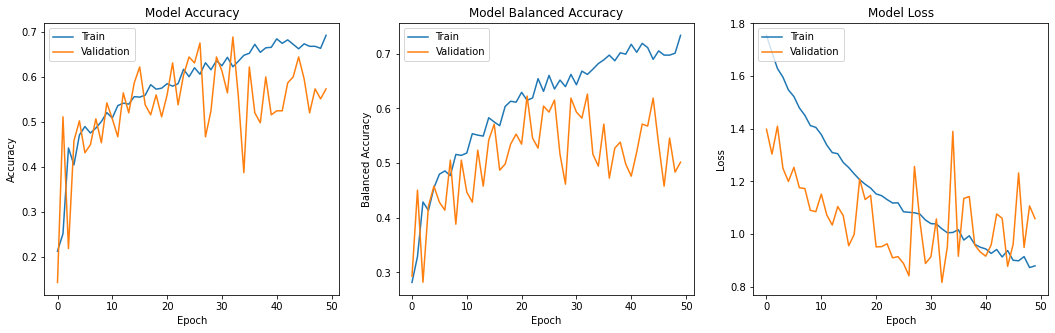

In [17]:
# plot the training history

history_plot(vanila_history, name='vanila')

As we can see from the above history, a vanila model can reach 60% balanced accuracy after 50 epochs. However, it starts overfitting since then as the gap between training accuracy and testing accuracy are larger and larger.

### Transfer Learning and Data Augmentation
As only 1000+ images are given to train our model, the dataset is rather small. And the vanila CNN model has overfitted easily on the small dataset. Thus, the following two improvements have been made:  
1. Use a pretrained model for better feature extraction.
2. Apply data augmentation to supplement our small dataset and prevent overfitting.  
VGG19 is used for its feature extraction ability and light-weighted structure thus easy to train.

#### Load data

In [18]:
# load image and perform data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_csv, directory=TRAIN_ROOT, 
                              x_col='filename', y_col='class', 
                              color_mode='rgb',
                              batch_size=BATCH_SIZE, shuffle=True,
                              target_size=(IMG_HEIGHT, IMG_WIDTH), subset='training',
                              class_mode='raw')

val_generator = train_datagen.flow_from_dataframe(dataframe=train_csv, directory=TRAIN_ROOT, 
                              x_col='filename', y_col='class', 
                              color_mode='rgb',
                              batch_size=BATCH_SIZE, shuffle=False,
                              target_size=(IMG_HEIGHT, IMG_WIDTH), subset='validation',
                              class_mode='raw')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_csv, directory=TEST_ROOT, 
                              x_col='filename', color_mode='rgb',
                              batch_size=BATCH_SIZE, shuffle=False,
                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                              class_mode=None)

Found 902 validated image filenames.
Found 225 validated image filenames.
Found 484 validated image filenames.


#### Build model

In [19]:
# download basemodel

tf.keras.backend.clear_session()

# Create the base model from the pre-trained model VGG19
VGG19base_model = tf.keras.applications.VGG19(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3),
                            include_top=False,
                            weights='imagenet')
VGG19base_model.trainable = False # freeze base model and only train top layers

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
# build the VGG19 based model

feature_batch = tf.keras.layers.GlobalMaxPooling2D()(VGG19base_model.output)
dense = tf.keras.layers.Dense(32, activation='relu')(feature_batch)
outputs = tf.keras.layers.Dense(4, activation='softmax')(dense)
VGG19_model = tf.keras.models.Model(inputs=VGG19base_model.input, outputs=outputs)

#### Train top layers

In [0]:
# train the top layer of the model

BASE_LR = 1e-4
INIT_EPOCH = 30

VGG19_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=BASE_LR), loss='sparse_categorical_crossentropy', 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='cat_acc'), BalancedSparseCategoricalAccuracy(name='balanced_cat_acc')])

# callbacks
lrs = tf.keras.callbacks.LearningRateScheduler(lambda epoch: BASE_LR*10 if epoch < INIT_EPOCH/2 else BASE_LR) 
mc = tf.keras.callbacks.ModelCheckpoint('VGG19_model.h5', monitor='val_balanced_cat_acc', save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_balanced_cat_acc', patience=10, mode='max', baseline=None, restore_best_weights=True)


VGG19_history = VGG19_model.fit(train_generator, class_weight=CLASS_WEIGHT, epochs=INIT_EPOCH, steps_per_epoch=train_generator.samples/BATCH_SIZE, 
          validation_data=val_generator, validation_steps=val_generator.samples/BATCH_SIZE, callbacks=[mc, es, lrs])

# output has been cleared
clear_output()

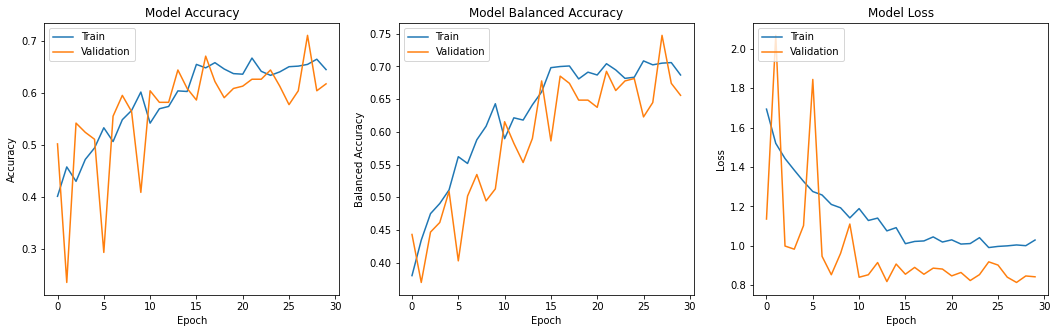

evaluating:
8/7 [==================================] - 4s 539ms/step - loss: 0.8218 - cat_acc: 0.6667 - balanced_cat_acc: 0.6960
predicting:
16/15 [===============================] - 230s 14s/step
(484,)
writing submission


In [22]:
# plot training history and save the prediction

history_plot(VGG19_history, name='VGG19')
eval_and_save(VGG19_model, val_generator, test_generator, 'VGG19_')

From the above picture, we can see that the model with 2 dense layer on the top can achieve above 60% balanced accuracy after 30 epoches. It does not out perform the vanila model a lot. Perhaps it is because the trainable variables are restricted to the top layers. The model does not have much learning capability.

#### Fine tuning
To improve the learning capability, we unfrozen the later layers of the model and fine tune it.

In [0]:
# unfrozen the top half of the layers

for layer in VGG19_model.layers[-8:]:
  layer.trainable = True

VGG19_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=BASE_LR/10), loss='sparse_categorical_crossentropy', 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='cat_acc'), BalancedSparseCategoricalAccuracy(name='balanced_cat_acc')])

In [0]:
# train for another 50 epochs with a smaller learning rate

FINE_EPOCH = 50

lrs = tf.keras.callbacks.LearningRateScheduler(lambda epoch: BASE_LR/10 if epoch < INIT_EPOCH+FINE_EPOCH/2 else BASE_LR/50)

VGG19_fine_history = VGG19_model.fit(train_generator, class_weight=CLASS_WEIGHT, epochs=INIT_EPOCH+FINE_EPOCH, initial_epoch = VGG19_history.epoch[-1], steps_per_epoch=train_generator.samples/BATCH_SIZE, 
          validation_data=val_generator, validation_steps=val_generator.samples/BATCH_SIZE, callbacks=[mc, es, lrs])

# output cleared
clear_output()

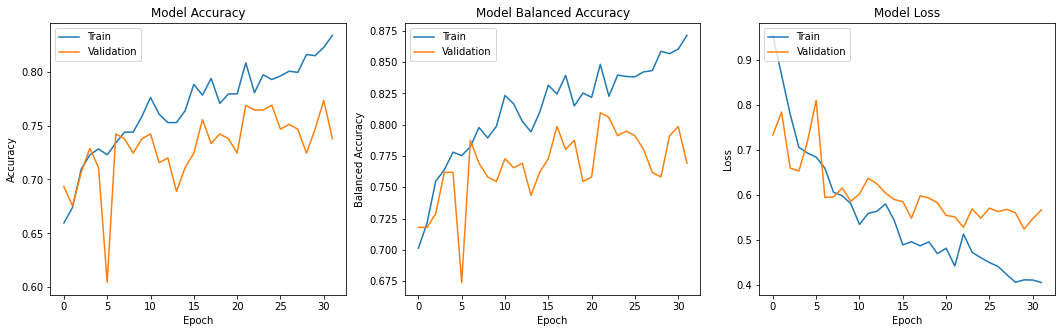

evaluating:
8/7 [==================================] - 5s 617ms/step - loss: 0.5650 - cat_acc: 0.7644 - balanced_cat_acc: 0.8059
predicting:
16/15 [===============================] - 5s 291ms/step
(484,)
writing submission


In [25]:
# plot learning history and save predictions

history_plot(VGG19_fine_history, name='VGG19_fine_')
eval_and_save(VGG19_model, val_generator, test_generator, 'VGG19_fine_')

As shown in the above figures, the fine tuned model achieved a 80% balanced accuracy on both training and evaluation accuracy.

#### Fine tune whole model
Further unfrozen all the layers and train for another 20 epochs.

In [0]:
# unfrozen all the layers

VGG19_model.trainable = True

VGG19_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=BASE_LR/50), loss='sparse_categorical_crossentropy', 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='cat_acc'), BalancedSparseCategoricalAccuracy(name='balanced_cat_acc')])

In [0]:
# train for another 20 epochs with a smaller learning rate

FINE_EPOCH2 = 20

lrs = tf.keras.callbacks.LearningRateScheduler(lambda epoch: BASE_LR/50 if epoch < INIT_EPOCH+FINE_EPOCH+FINE_EPOCH2/2 else BASE_LR/100)

VGG19_fine_history2 = VGG19_model.fit(train_generator, class_weight=CLASS_WEIGHT, epochs=INIT_EPOCH+FINE_EPOCH+FINE_EPOCH2, initial_epoch = VGG19_fine_history.epoch[-1], steps_per_epoch=train_generator.samples/BATCH_SIZE, 
          validation_data=val_generator, validation_steps=val_generator.samples/BATCH_SIZE, callbacks=[mc, es, lrs])

# output cleared
clear_output()

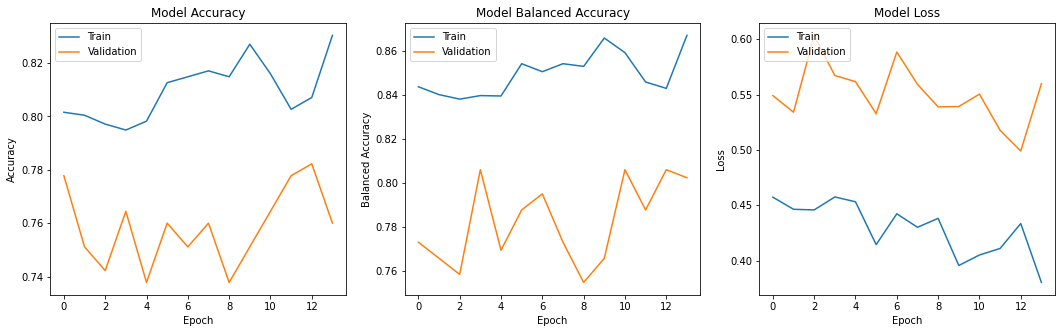

evaluating:
8/7 [==================================] - 4s 528ms/step - loss: 0.5641 - cat_acc: 0.7378 - balanced_cat_acc: 0.7839
predicting:
16/15 [===============================] - 5s 293ms/step
(484,)
writing submission


In [28]:
# plot learning history and save predictions

history_plot(VGG19_fine_history2, name='VGG19_fine2_')
eval_and_save(VGG19_model, val_generator, test_generator, 'VGG19_fine2_')

The model is not improving very much.

#### Evaluate and predict with the best model

In [29]:
loaded_model = tf.keras.models.load_model('VGG19_model.h5', custom_objects={'BalancedSparseCategoricalAccuracy': BalancedSparseCategoricalAccuracy()})
eval_and_save(loaded_model, val_generator, test_generator, 'best_')

evaluating:
8/7 [==================================] - 5s 614ms/step - loss: 0.5564 - cat_acc: 0.7778 - balanced_cat_acc: 0.7875
predicting:
16/15 [===============================] - 5s 295ms/step
(484,)
writing submission


#### Error Analysis

In [0]:
# get y_pred and y_true

VGG19_model.trainable = False
y_pred = []
y_true = []

for i, (imgs, labels) in enumerate(val_generator):
  y_pred += list(VGG19_model.predict(imgs).argmax(axis=1))
  y_true += list(labels)
  if i == 7:
    break

In [0]:
# calculate sample weight according to balanced accuracy
sample_weight = np.where(np.array(y_true)==label2int['covid'], 5, 1)

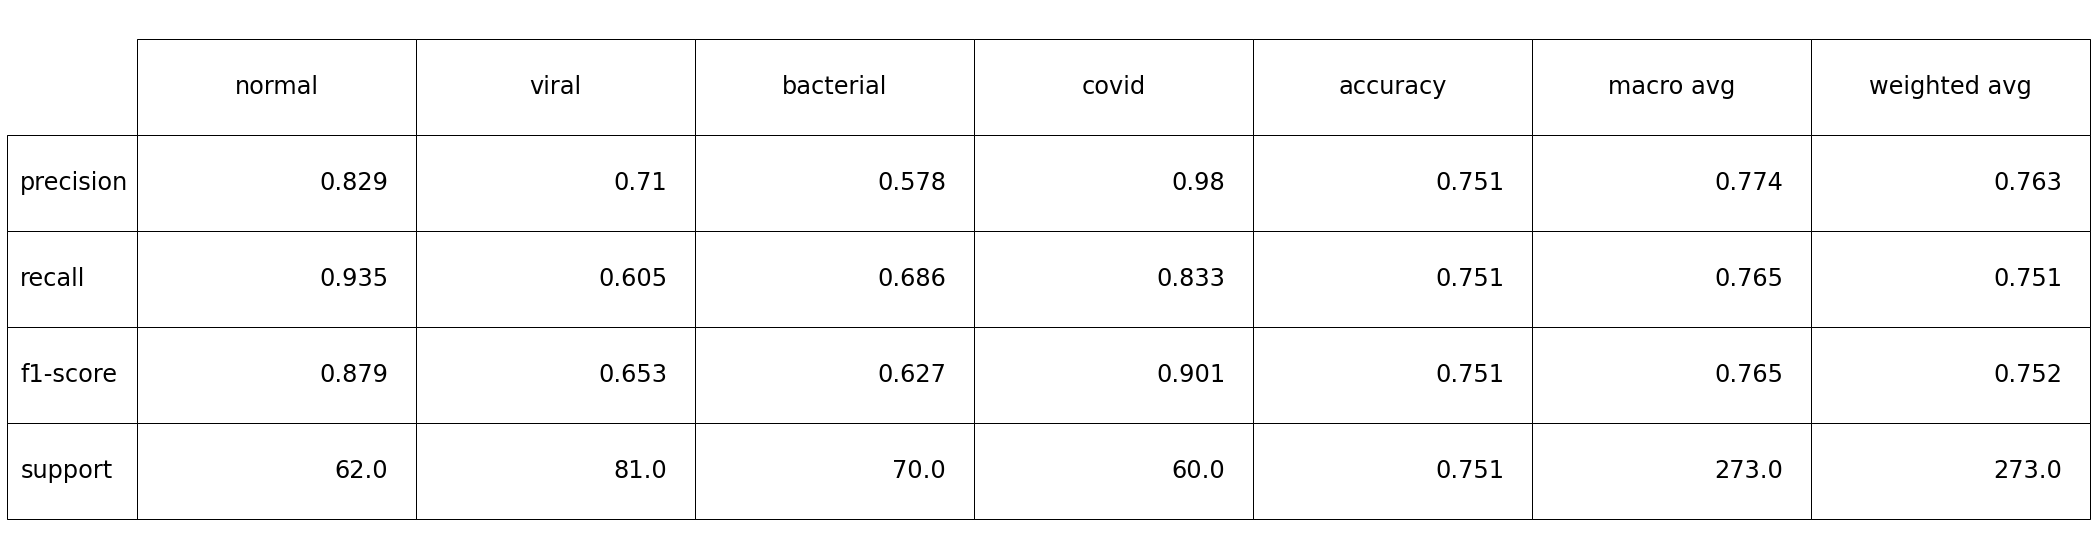

In [86]:
# build classification report for precision/recall/accuracy/f1-score

from sklearn.metrics import classification_report
results = classification_report(y_true, y_pred, target_names=int2label, labels=[0,1,2,3], sample_weight=sample_weight, output_dict=True)
results = pd.DataFrame(results).round(3)
plt.figure(figsize=(10,10))
ax = plt.gca()
table = pd.plotting.table(ax, results, loc='center', colWidths=[0.1]*8)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
table.auto_set_font_size(False)
table.set_fontsize(24)
table.scale(5, 8)
for pos in ['right','top','bottom','left']:
  plt.gca().spines[pos].set_visible(False)
plt.savefig('classification_report.png')

In [87]:
print(results)

           normal   viral  bacterial   covid  accuracy  macro avg  weighted avg
precision   0.829   0.710      0.578   0.980     0.751      0.774         0.763
recall      0.935   0.605      0.686   0.833     0.751      0.765         0.751
f1-score    0.879   0.653      0.627   0.901     0.751      0.765         0.752
support    62.000  81.000     70.000  60.000     0.751    273.000       273.000


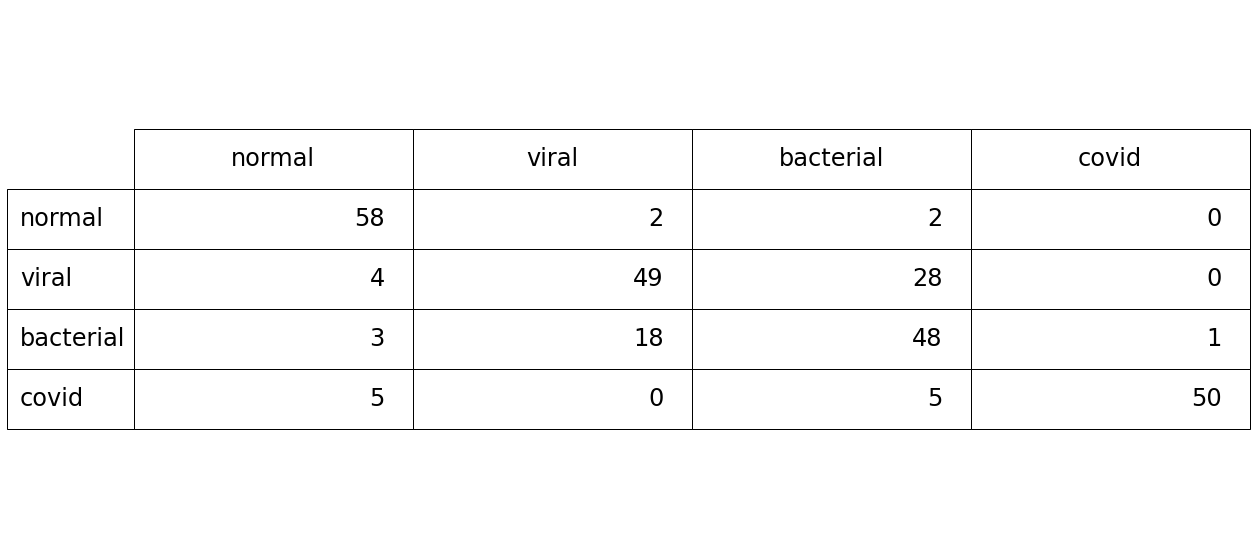

In [88]:
# build confusion matrix
from sklearn.metrics import confusion_matrix
results = pd.DataFrame(confusion_matrix(y_true, y_pred, labels=[0,1,2,3], sample_weight=sample_weight), index=int2label, columns=int2label)
plt.figure(figsize=(10,10))
ax = plt.gca()
table = pd.plotting.table(ax, results, loc='center', colWidths=[0.1]*5)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
table.auto_set_font_size(False)
table.set_fontsize(24)
table.scale(5, 5)
for pos in ['right','top','bottom','left']:
  plt.gca().spines[pos].set_visible(False)
plt.savefig('confusion_matrix.png')

In [85]:
print(results)

           normal  viral  bacterial  covid
normal         58      2          2      0
viral           4     49         28      0
bacterial       3     18         48      1
covid           5      0          5     50


### Interpretability
It's well known that it's very hard to interprete deep neural networks. In this section, the intermediate outputs are plotted to show what is happening inside the CNN.  
In this section, we are going to compare a COVID lung with a normal lung.

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

VGG19_model.trainable = False

imgs, labels = next(train_generator)
print(imgs.shape)

(32, 256, 256, 3)


In [0]:
# model to generate intermediate outputs

inter_model = tf.keras.Model(inputs=VGG19_model.input, outputs=[VGG19_model.get_layer('block1_pool').output, VGG19_model.get_layer('block2_pool').output,
                              VGG19_model.get_layer('block3_pool').output, VGG19_model.get_layer('block4_pool').output,
                              VGG19_model.get_layer('block5_pool').output])

##### Normal


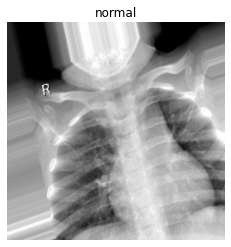

In [64]:
# original picture
category = 'normal'

k = np.argmax(labels==label2int[category])

plt.imshow(imgs[k])
plt.axis('off')
plt.title(int2label[labels[k]])
plt.savefig(category+'_raw.png')

In [0]:
# intermediate output

inter_output = inter_model(imgs[k:k+1,:,:,:])

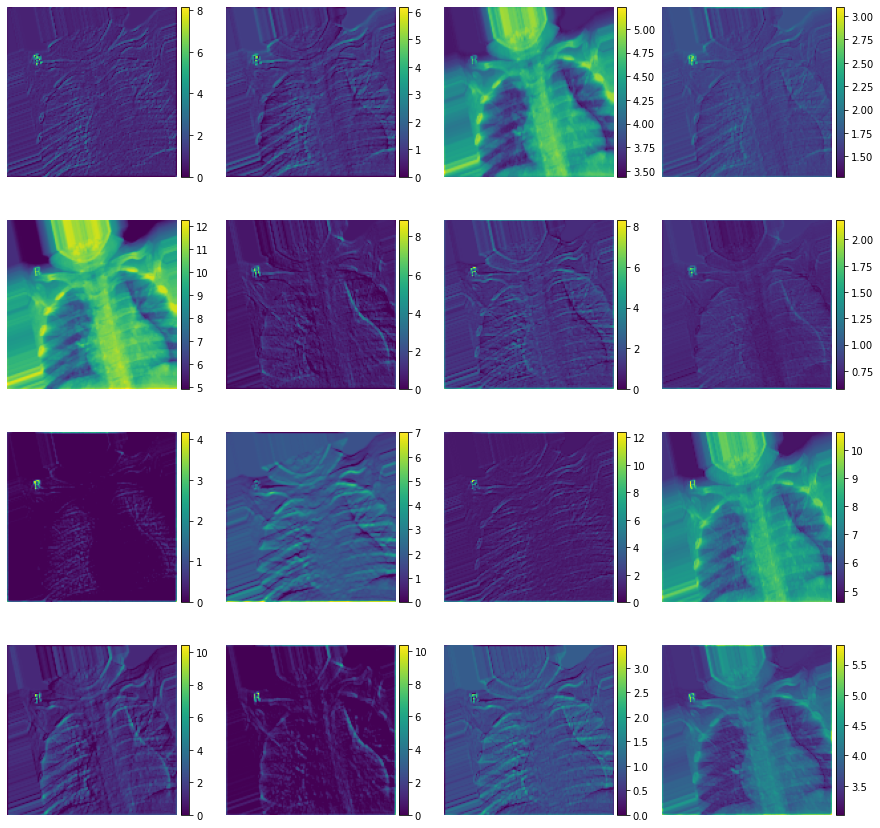

In [66]:
# output of first CNN block

fig = plt.figure(figsize=(15,15))

for i in range(16):
  plt.subplot(4,4,i+1)
  im = plt.imshow(inter_output[0][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_1.png')

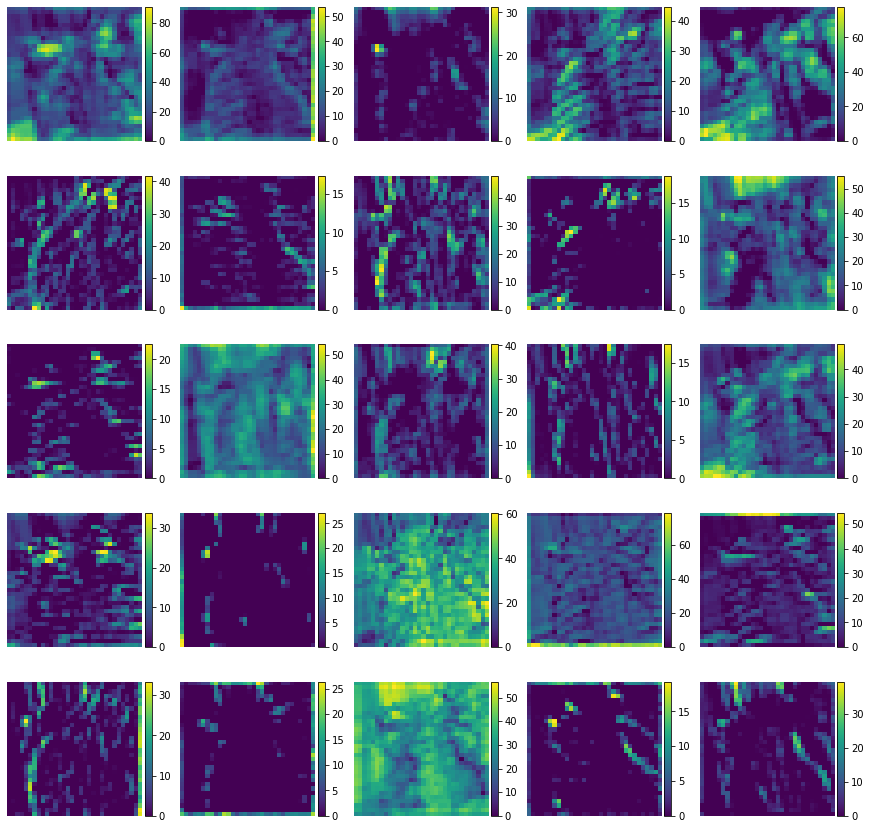

In [67]:
# output of the third CNN block

fig = plt.figure(figsize=(15, 15))

for i in range(25):
  plt.subplot(5,5,i+1)
  im = plt.imshow(inter_output[2][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_2.png')

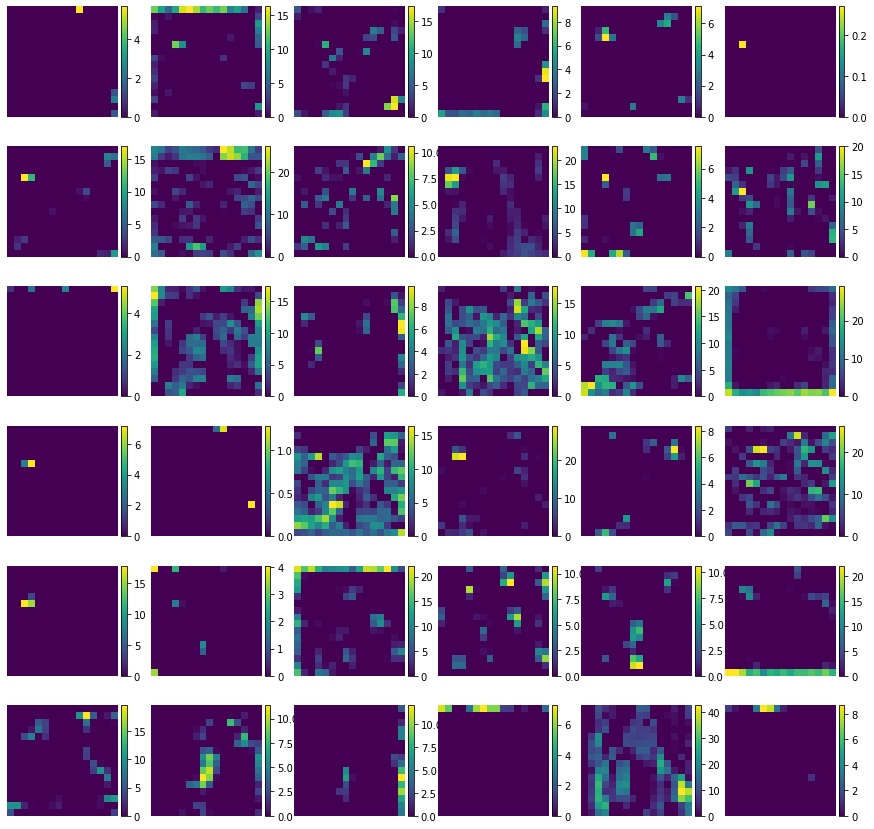

In [68]:
# output of the fourth CNN block

fig = plt.figure(figsize=(15,15))

for i in range(36):
  plt.subplot(6,6,i+1)
  im = plt.imshow(inter_output[3][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_3.png')

##### COVID


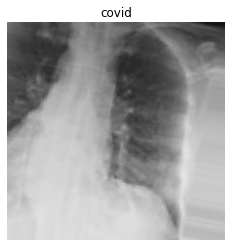

In [69]:
# original picture
category = 'covid'

k = np.argmax(labels==label2int[category])

plt.imshow(imgs[k])
plt.axis('off')
plt.title(int2label[labels[k]])
plt.savefig(category+'_raw.png')

In [0]:
# intermediate output

inter_output = inter_model(imgs[k:k+1,:,:,:])

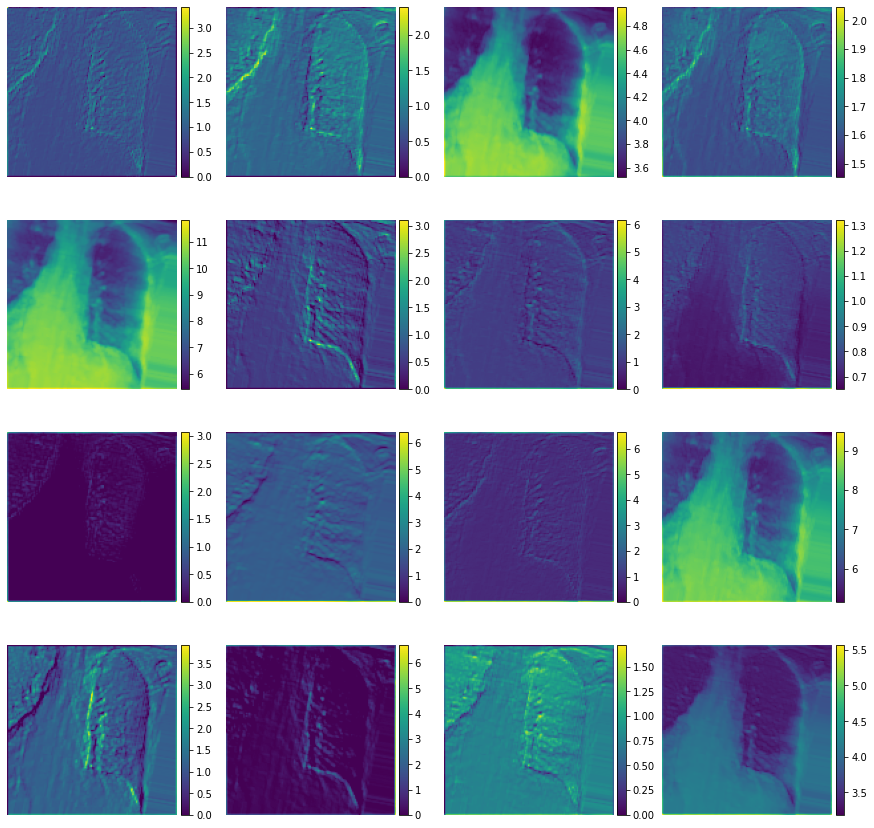

In [71]:
# output of first CNN block

fig = plt.figure(figsize=(15,15))

for i in range(16):
  plt.subplot(4,4,i+1)
  im = plt.imshow(inter_output[0][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_1.png')

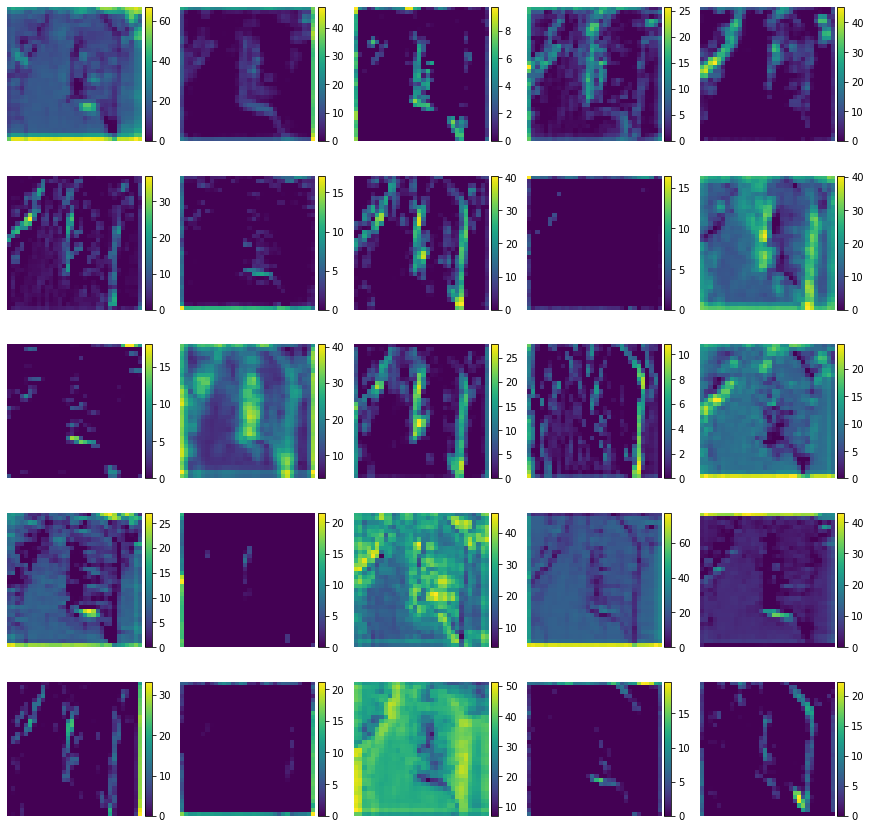

In [72]:
# output of the third CNN block

fig = plt.figure(figsize=(15, 15))

for i in range(25):
  plt.subplot(5,5,i+1)
  im = plt.imshow(inter_output[2][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_2.png')

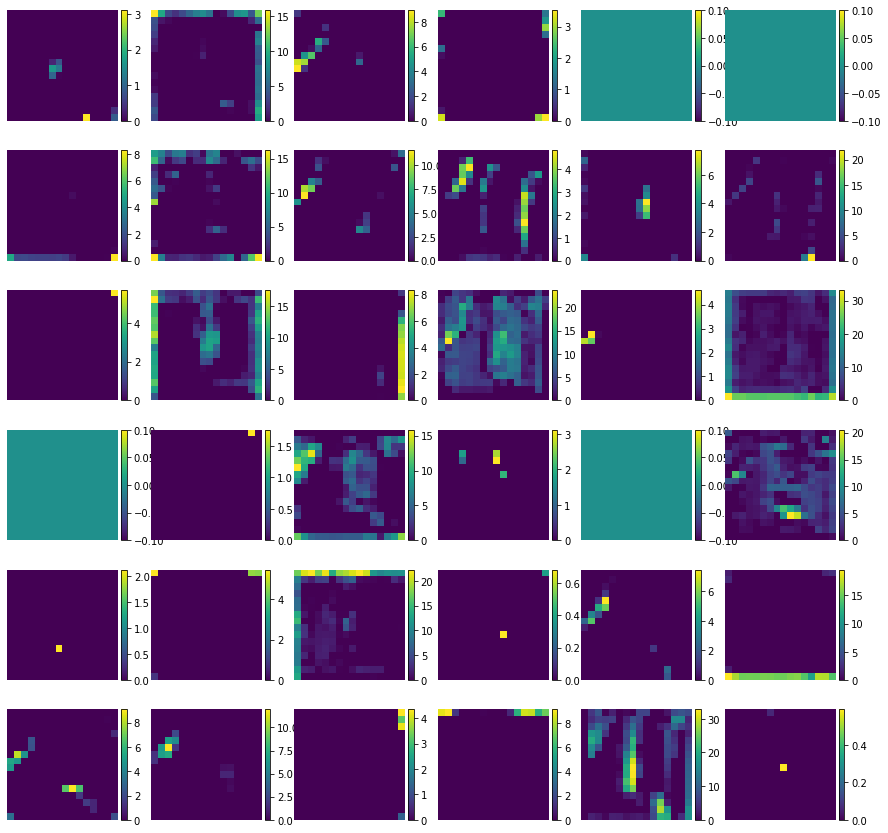

In [73]:
# output of the fourth CNN block

fig = plt.figure(figsize=(15,15))

for i in range(36):
  plt.subplot(6,6,i+1)
  im = plt.imshow(inter_output[3][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_3.png')

##### Bacterial


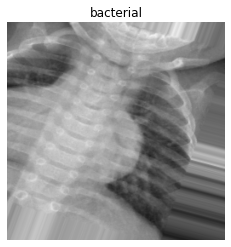

In [74]:
# original picture
category = 'bacterial'

k = np.argmax(labels==label2int[category])

plt.imshow(imgs[k])
plt.axis('off')
plt.title(int2label[labels[k]])
plt.savefig(category+'_raw.png')

In [0]:
# intermediate output

inter_output = inter_model(imgs[k:k+1,:,:,:])

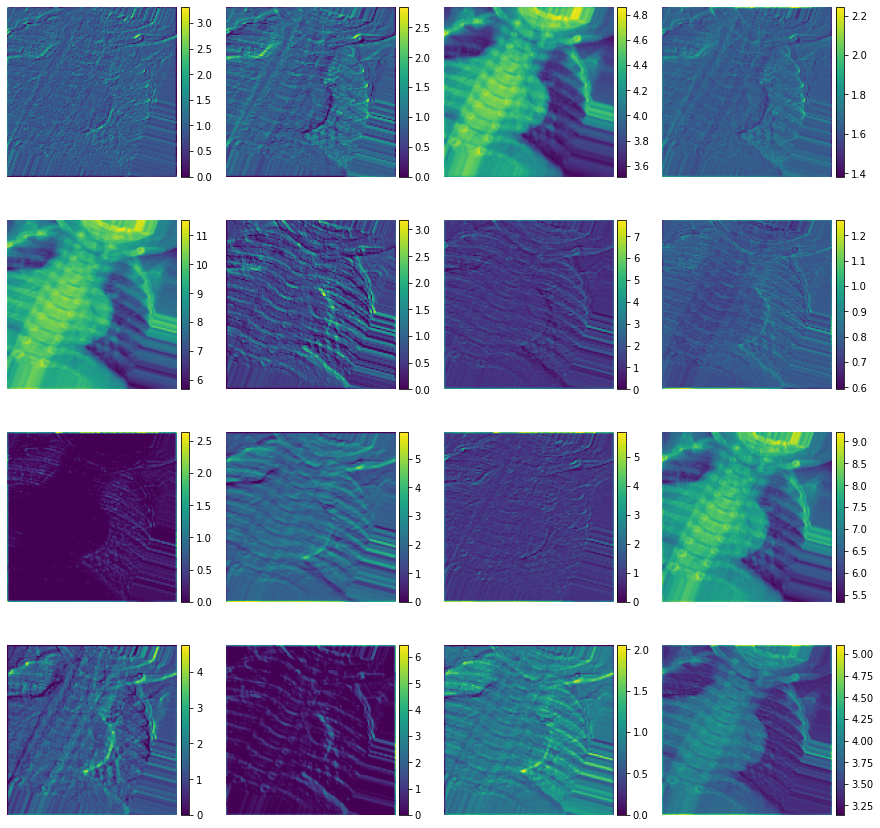

In [76]:
# output of first CNN block

fig = plt.figure(figsize=(15,15))

for i in range(16):
  plt.subplot(4,4,i+1)
  im = plt.imshow(inter_output[0][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_1.png')

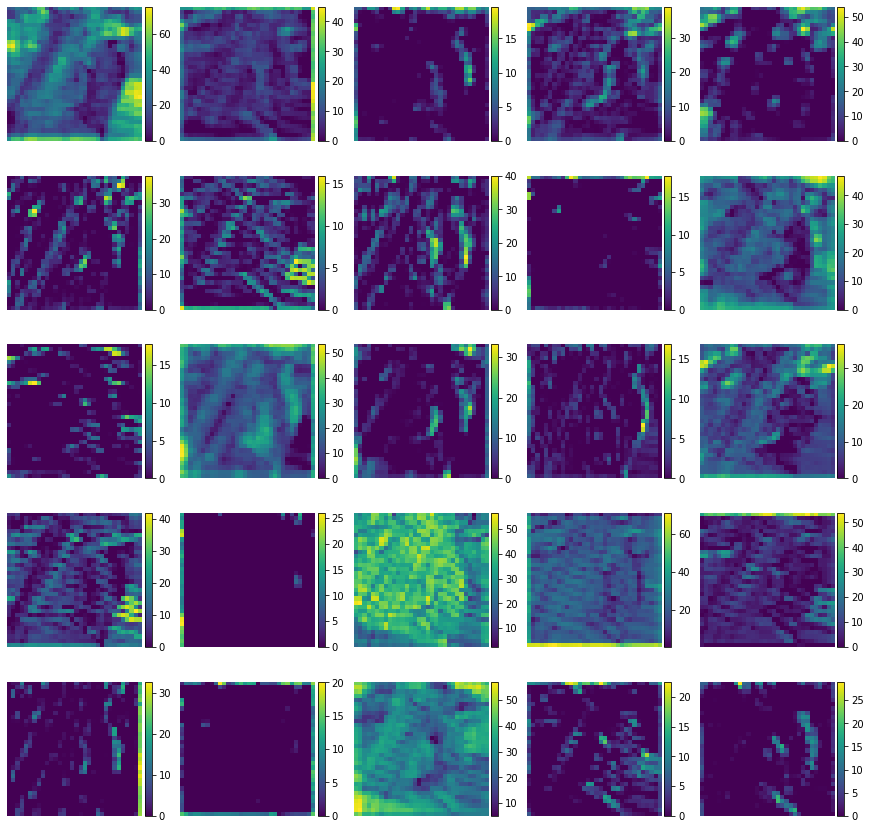

In [77]:
# output of the third CNN block

fig = plt.figure(figsize=(15, 15))

for i in range(25):
  plt.subplot(5,5,i+1)
  im = plt.imshow(inter_output[2][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_2.png')

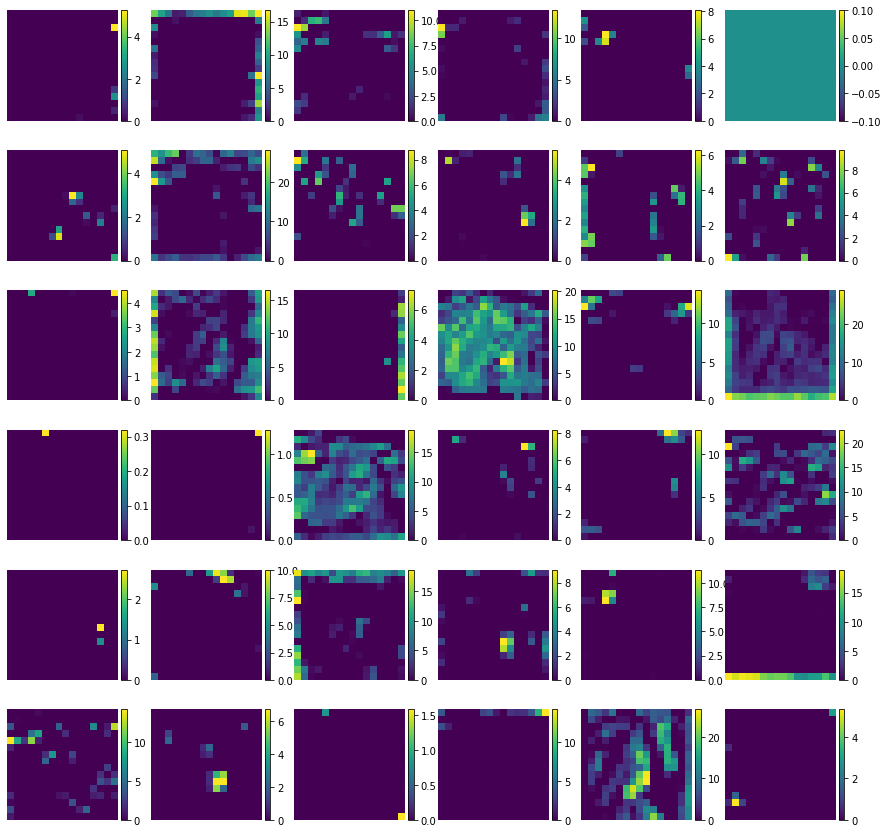

In [78]:
# output of the fourth CNN block

fig = plt.figure(figsize=(15,15))

for i in range(36):
  plt.subplot(6,6,i+1)
  im = plt.imshow(inter_output[3][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_3.png')

##### Viral


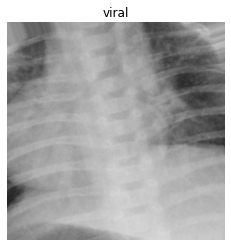

In [80]:
# original picture
category = 'viral'

k = np.argmax(labels==label2int[category])

plt.imshow(imgs[k])
plt.axis('off')
plt.title(int2label[labels[k]])
plt.savefig(category+'_raw.png')

In [0]:
# intermediate output

inter_output = inter_model(imgs[k:k+1,:,:,:])

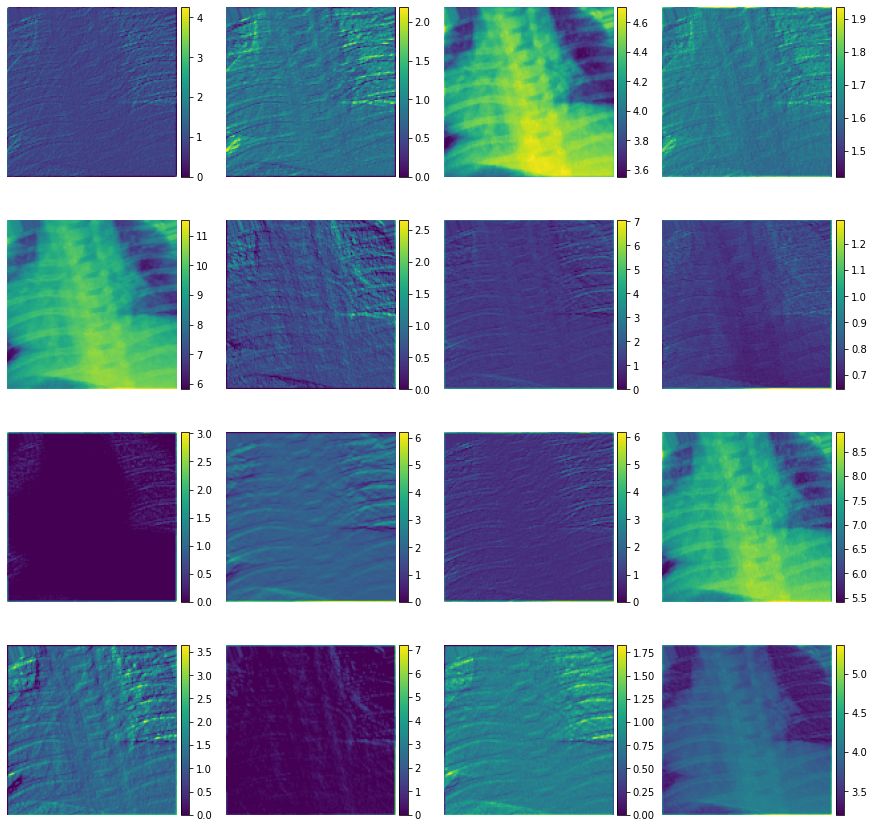

In [82]:
# output of first CNN block

fig = plt.figure(figsize=(15,15))

for i in range(16):
  plt.subplot(4,4,i+1)
  im = plt.imshow(inter_output[0][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_1.png')

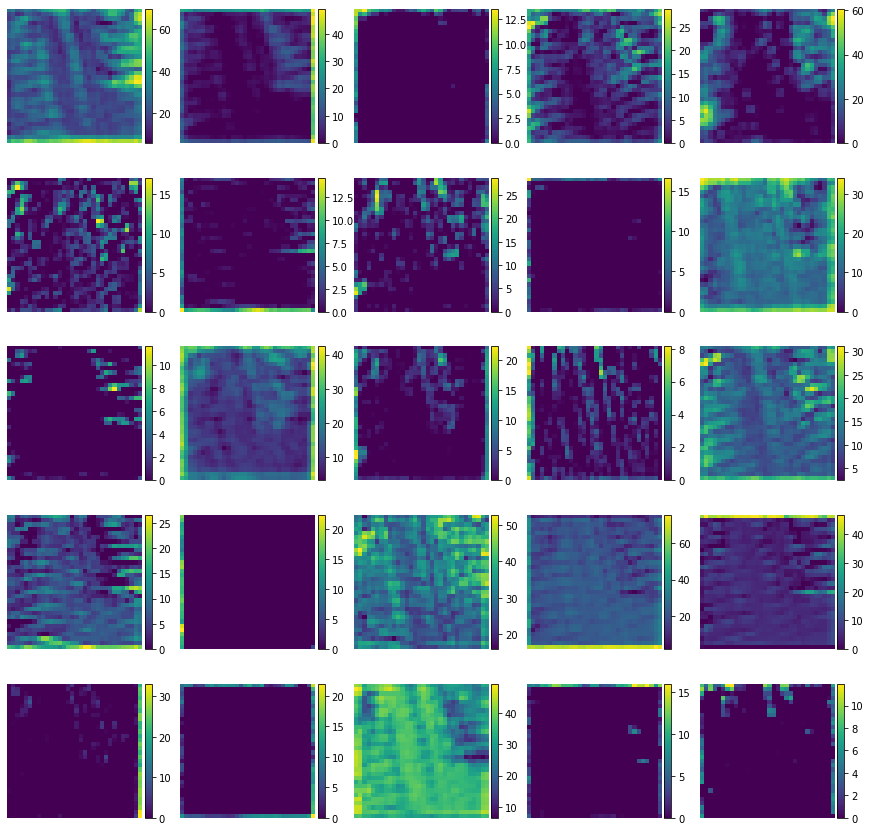

In [83]:
# output of the third CNN block

fig = plt.figure(figsize=(15, 15))

for i in range(25):
  plt.subplot(5,5,i+1)
  im = plt.imshow(inter_output[2][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_2.png')

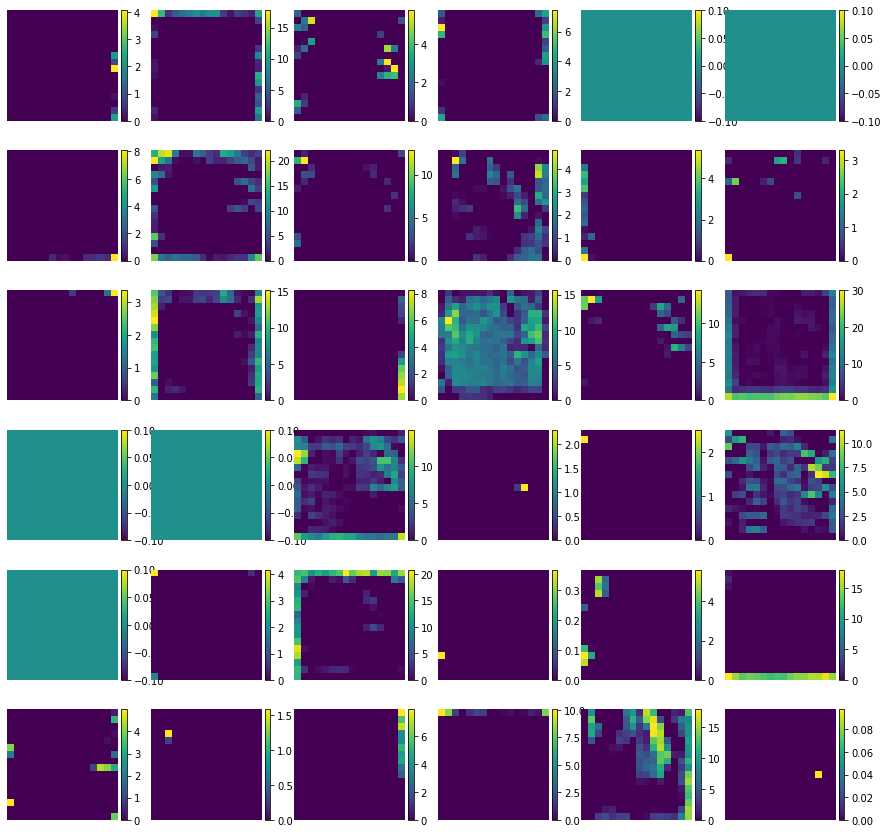

In [84]:
# output of the fourth CNN block

fig = plt.figure(figsize=(15,15))

for i in range(36):
  plt.subplot(6,6,i+1)
  im = plt.imshow(inter_output[3][0,:,:,i])
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  ax.axis('off')
  fig.colorbar(im, cax=cax)
plt.savefig(category+'_3.png')

##### Conclusion:
As shown above, the bottom several CNN blocks are able to recognizing simple features and tell bones from lungs.  
The outputs of deeper CNN blocks are harder to interprete but generally capture more complicated features of the image.  
In this way, we can see what each block is doing and thus it is more interprateble.  